# 1.Setup and Load Data

### 1.1 Install Dependencies and setup

In [1220]:
import tensorflow as tf
import os

In [1222]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [1224]:
# Avoid OOM error by setting GPU Memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Remove Dodgy Images 

In [1227]:
import cv2
import imghdr

In [1229]:
data_dir = 'data'

In [1231]:
os.listdir(data_dir)

['happy', 'sad']

In [1233]:
image_exts = ['jpg', 'jpeg', 'png', 'bmp']

In [1235]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Load Data

In [1238]:
import numpy as np
from matplotlib import pyplot as plt

In [1240]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 286 files belonging to 2 classes.


In [1242]:
data_iterator = data.as_numpy_iterator()

In [1244]:
# Each time get another batch from iterator
batch = data_iterator.next()

In [1246]:
# Images are represented as numpy arrays
# (batch_size, width, height, channels(RGB))
batch[0].shape

(32, 256, 256, 3)

In [1248]:
# 1 class = sad people 
# 0 class = happy people 
# 2D array = [image, label(Happy or Sad)]
batch[1]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0])

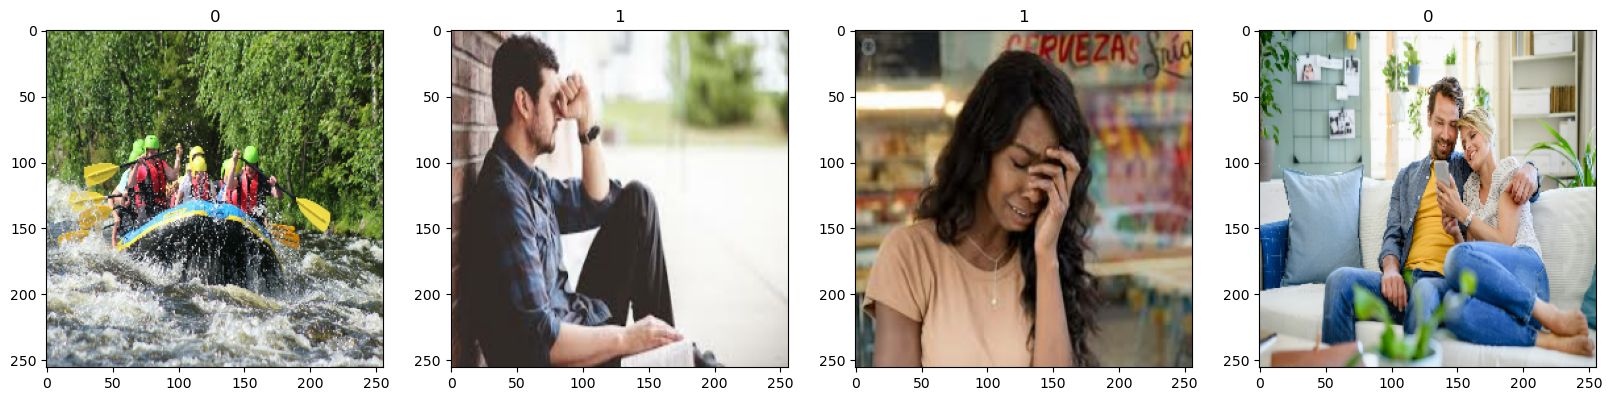

In [1250]:
fix, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2.Preprocess Data

### 2.1 Scale Data

In [1254]:
data = data.map(lambda x,y: (x/255, y))

In [1256]:
data.as_numpy_iterator().next()

(array([[[[0.8509804 , 0.87058824, 0.88235295],
          [0.8509804 , 0.87058824, 0.88235295],
          [0.8509804 , 0.87058824, 0.88235295],
          ...,
          [0.7058824 , 0.7529412 , 0.7529412 ],
          [0.7058824 , 0.7529412 , 0.7529412 ],
          [0.7019608 , 0.7490196 , 0.7490196 ]],
 
         [[0.8509804 , 0.87058824, 0.88235295],
          [0.8509804 , 0.87058824, 0.88235295],
          [0.8509804 , 0.87058824, 0.88235295],
          ...,
          [0.7019608 , 0.7490196 , 0.7490196 ],
          [0.69803923, 0.74509805, 0.74509805],
          [0.70165443, 0.74871325, 0.74871325]],
 
         [[0.8509804 , 0.87058824, 0.88235295],
          [0.8509804 , 0.87058824, 0.88235295],
          [0.8509804 , 0.87058824, 0.88235295],
          ...,
          [0.69803923, 0.74509805, 0.74509805],
          [0.69411767, 0.7411765 , 0.7411765 ],
          [0.69411767, 0.7411765 , 0.7411765 ]],
 
         ...,
 
         [[0.8392157 , 0.85882354, 0.87058824],
          [0.83921

### 2.2 Split Data

In [1259]:
total_batch = len(data)
total_batch

9

In [1261]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [1263]:
train_size+val_size+test_size

9

In [1265]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3.Deep Learning 

### 3.1 Build deep learning Model

In [1269]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [1271]:
model = Sequential()

In [1273]:
# Layers
# Conv2D(kernel_no, kernel_size, stride, activation_function, .....)

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# dense(neurons_no, function)
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # output layer with 1 neuron 

In [1275]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [1277]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Train

In [1280]:
logdir = 'logs'

In [1282]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [1284]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 741ms/step - accuracy: 0.5560 - loss: 1.5993 - val_accuracy: 0.5469 - val_loss: 0.7478
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 949ms/step - accuracy: 0.4650 - loss: 0.7575 - val_accuracy: 0.5625 - val_loss: 0.6716
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 905ms/step - accuracy: 0.5363 - loss: 0.6864 - val_accuracy: 0.6562 - val_loss: 0.6659
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 850ms/step - accuracy: 0.6289 - loss: 0.6789 - val_accuracy: 0.6250 - val_loss: 0.6121
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 921ms/step - accuracy: 0.6532 - loss: 0.6155 - val_accuracy: 0.5625 - val_loss: 0.6465
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 925ms/step - accuracy: 0.6216 - loss: 0.6136 - val_accuracy: 0.8594 - val_loss: 0.4996
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 928ms/step - accuracy: 0.7841 - loss: 0.4956 - val_accuracy: 0.7344 - val_loss: 0.5528
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 920ms/step - accuracy: 0.7664 - loss: 0.5039 - val_accuracy: 0.8125 - val_loss:

### 3.3 Plot Performance

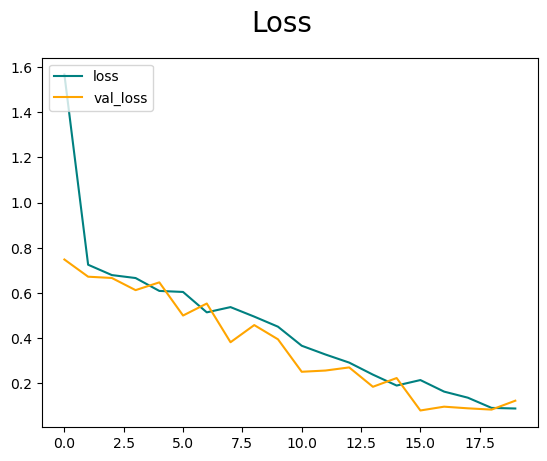

In [1289]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

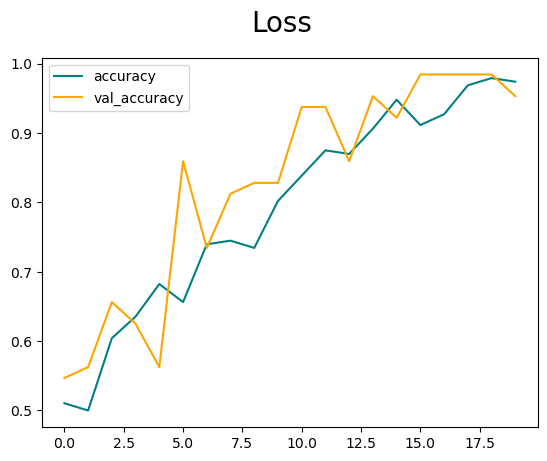

In [1291]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4.Evaluate Performance

### 4.1 Evaluate

In [1296]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [1300]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [1306]:
# length of test data i.e number of batches
len(test)

1

In [1329]:
# Test model using test data

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [1331]:
print(f'Precision: {pre.result().numpy()},\nRecall: {re.result().numpy()},\nBinaryAccuracy: {acc.result().numpy()}')

Precision: 0.9615384340286255,
Recall: 0.9615384340286255,
BinaryAccuracy: 0.9666666388511658


### 4.2 Test

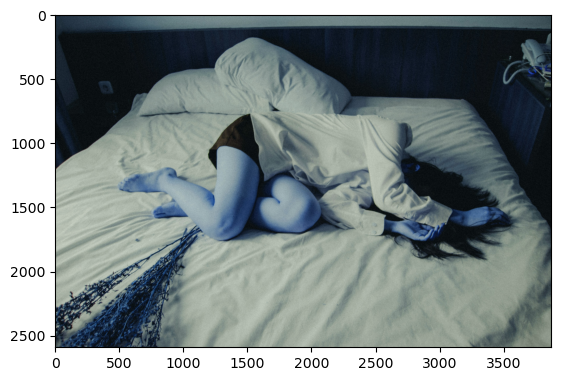

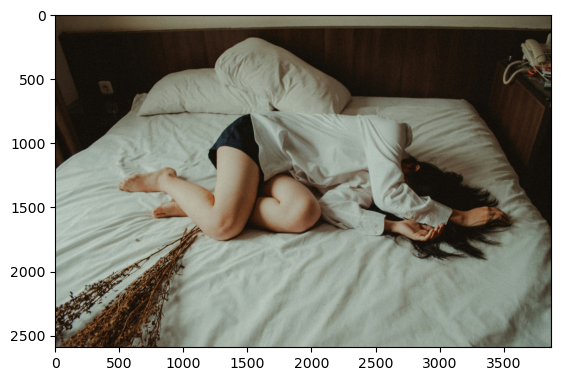

In [1383]:
# Image - BGR
img = cv2.imread('s.jpg')
plt.imshow(img)
plt.show()

# Convert BGR -> RGB
img = cv2.imread('s.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

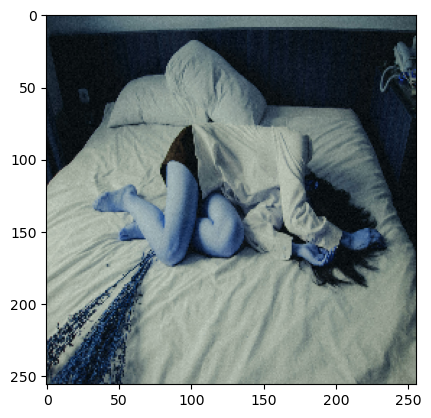

In [1385]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [1387]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [1389]:
yhat

array([[0.9682838]], dtype=float32)

In [1391]:
if yhat>0.5:
    print("Predicted class is Sad")
else:
    print("Predicted class is Happy")

Predicted class is Sad


# 5. Save the Model

In [1396]:
from tensorflow.keras.models import load_model

In [1398]:
model.save(os.path.join('models','FaceClassification.h5'))

2024-09-10 23:47:43,633 - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


### 5.1 Reload the Model

In [1403]:
new_model = load_model(os.path.join('models', 'FaceClassification.h5'))

2024-09-10 23:49:58,903 - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [ ]:
# new_model.predict()